# 卷积层

一张 12,000,000 像素的猫或者狗的图片，分RGB三种颜色，如果使用单隐藏层的 MLP 处理，模型有 3.6B 个参数，远多于世界上所有猫和狗的数量。

## 1. 识别器的原则

- 平移不变性（在图片的哪个位置都能识别到）
- 局部性（不需要看整张图就能识别）

## 2. 重新考察全连接层

- 将输入和输出变形为矩阵（宽度，高度）
- 将权重变形为4-D张量 $(h, w)$ 到 $(h^\prime, w^\prime)$

$$h_{i,j} = \sum_{k,l} w_{i,j,k,l}x_{k,l} = \sum_{a,b} v_{i,j,a,b}x_{i+a,j+b}$$

- $v$ 是 $w$ 的重新索引 $v_{i,j,i+a,j+b}$

## 3. 原则 #1 - 平移不变性

- x的平移导致h的平移 $h_{i,j} = \sum_{a,b} v_{i,j,a,b} x_{i+a,j+b}$
- v不应该依赖于(i, j)
- 解决方案：$v_{i,j,a,b} = v_{a,b}$

$h_{i,j} = \sum_{a,b} v_{a,b}x_{i+a,j+b}$

这就是二维<del>卷积</del>交叉相关

## 4. 原则 #2 - 局部性

$h_{i,j} = \sum_{a,b} \mathbf{v}_{a,b} \mathbf{x}_{i+a,j+b}$

- 当评估 $h_{i,j}$ 时，我们不应该用远离 $x_{i,j}$ 的参数
- 解决方案：当 $|a|, |b| > \Delta$ 时，使得 $v_{a,b} = 0$

$$h_{i,j} = \sum_{a=-\Delta}^{\Delta} \sum_{b=-\Delta}^{\Delta} v_{a,b} x_{i+a,j+b}$$

## 5. 小结

- 对全连接层使用平移不变性和局部性得到卷积层

$~~~~~~~~~~~h_{i,j} = \sum_{a,b} \mathbf{v}_{i,j,a,b} \mathbf{x}_{i+a,j+b}$

$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$⬇

$~~~~~~~~~~~h_{i,j} = \sum_{a=-\Delta}^{\Delta} \sum_{b=-\Delta}^{\Delta} \mathbf{v}_{a,b} \mathbf{x}_{i+a,j+b}$

## 6. 二维交叉相关

- 卷积核 (Kernel)，其实就是 $\mathbf{w}$
- 核是不随扫描的位置变化的，这就实现了平移不变性

## 7. 二维卷积层

- 输入 $\mathbf{X}: n_h \times n_w$
- 核 $\mathbf{W}: k_h \times k_w$
- 偏差 $b \in \mathbb{R}$
- 输出 $\mathbf{Y}: (n_h - k_h + 1) \times (n_w - k_w + 1)$

$\mathbf{Y} = \mathbf{X} \mathbf{W} + b$

$\mathbf{W}$ 和 $b$ 是可学习的参数

## 8. 例子

In [1]:
import torch

def corr2d(X, K):
    h, w = K.shape
    Y = torch.zeros(X.shape[0] - h + 1, X.shape[1] - w + 1)
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i+h, j:j+w] * K).sum()
    return Y

def merge_channel(a, b, c):
    h, w = a.shape
    return [[[a[i][j], b[i][j], c[i][j]] for j in range(w)] for i in range(h)]

In [2]:
import numpy as np
from PIL import Image


im = Image.open('../data/image/mhr.jpeg')
im_array = np.array(im)
im_grey = np.array(im.convert('L'))
im_array.shape, im_grey.shape

((1086, 724, 3), (1086, 724))

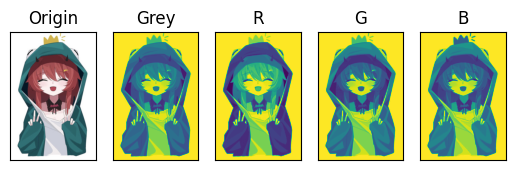

In [3]:
import matplotlib.pyplot as plt


lst = [
    ('Origin', im_array),
    ('Grey', im_grey),
    ('R', im_array[:, :, 0]),
    ('G', im_array[:, :, 1]),
    ('B', im_array[:, :, 2])
]

for i in range(5):
    plt.subplot(1, 5, i+1)
    fig = plt.imshow(Image.fromarray(lst[i][1]))
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.title(lst[i][0])

In [4]:
(merge_channel(im_array[:, :, 0], im_array[:, :, 1], im_array[:, :, 2]) == im_array).shape

(1086, 724, 3)

In [5]:
X0, X1, X2 = torch.tensor(im_array[:, :, 0]), torch.tensor(im_array[:, :, 1]), torch.tensor(im_array[:, :, 2])

不同的卷积核，会得到不同的效果

边缘检测

$\left[\begin{array}{c}
-1 & -1 & -1 \\
-1 & 8 & -1 \\
-1 & -1 & -1
\end{array}\right]$

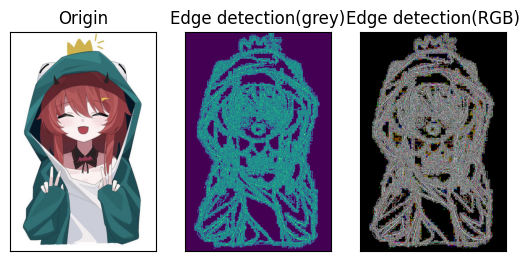

In [6]:
K1 = torch.tensor([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
X = torch.tensor(im_grey)
Y10 = corr2d(X, K1)
Y11 = merge_channel(
    corr2d(X0, K1),
    corr2d(X1, K1),
    corr2d(X2, K1)
)

lst = [
    ('Origin', im_array),
    ('Edge detection(grey)', np.array(Y10, dtype=np.uint8)),
    ('Edge detection(RGB)', np.array(Y11, dtype=np.uint8))
]
for i in range(3):
    plt.subplot(1, 3, i+1)
    fig = plt.imshow(Image.fromarray(lst[i][1]))
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.title(lst[i][0])

锐化

$\left[\begin{array}{c}
0 & -1 & 0 \\
-1 & 5 & -1 \\
0 & -1 & 0
\end{array}\right]$

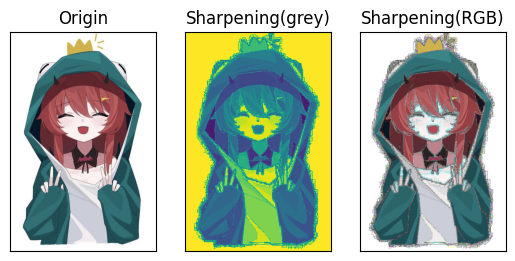

In [7]:
K2 = torch.tensor([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
X = torch.tensor(im_grey)
Y20 = corr2d(X, K2)
Y21 = merge_channel(
    corr2d(X0, K2),
    corr2d(X1, K2),
    corr2d(X2, K2)
)

lst = [
    ('Origin', im_array),
    ('Sharpening(grey)', np.array(Y20, dtype=np.uint8)),
    ('Sharpening(RGB)', np.array(Y21, dtype=np.uint8))
]
for i in range(3):
    plt.subplot(1, 3, i+1)
    fig = plt.imshow(Image.fromarray(lst[i][1]))
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.title(lst[i][0])

高斯模糊

$\frac{1}{16}\left[\begin{array}{c}
1 & 2 & 1 \\
2 & 4 & 2 \\
1 & 2 & 1
\end{array}\right]$

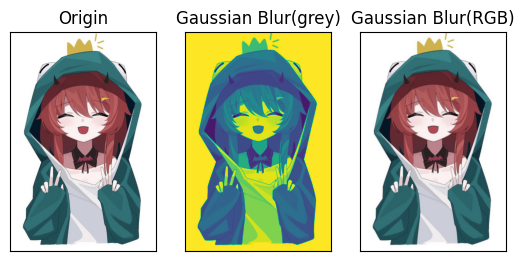

In [8]:
K3 = torch.tensor([[1, 2, 1], [2, 4, 2], [1, 2, 1]])/16
X = torch.tensor(im_grey)
Y30 = corr2d(X, K3)
Y31 = merge_channel(
    corr2d(X0, K3),
    corr2d(X1, K3),
    corr2d(X2, K3)
)

lst = [
    ('Origin', im_array),
    ('Gaussian Blur(grey)', np.array(Y30, dtype=np.uint8)),
    ('Gaussian Blur(RGB)', np.array(Y31, dtype=np.uint8))
]
for i in range(3):
    plt.subplot(1, 3, i+1)
    fig = plt.imshow(Image.fromarray(lst[i][1]))
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.title(lst[i][0])

In [9]:
# Image.fromarray(np.array(Y31, dtype=np.uint8))

In [10]:
# Image.fromarray(im_array)

## 9. 交叉相关 vs 卷积

- 二维交叉相关
- 二维卷积
- 由于对称性，在实际使用中没有区别

因为使用是一样的，所以没有使用数学上严格定义的卷积

## 10. 一维和三维交叉相关

- 一维：文本、语言、时需序列
- 二维：视频、医学图像、气象图像

## 11. 总结

- 卷积层将输入和核矩阵进行交叉相关，加上偏移后得到输出
- 核矩阵和偏移是可学习的参数
- 核矩阵的大小是超参数

## 12. 互相关运算

In [11]:
import torch
from torch import nn
from d2l import torch as d2l

def corr2d(X, K):
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i+h, j:j+w] * K).sum()
    return Y

验证上述二维互相关运算的输出

In [12]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

## 13. 实现二维卷积层

In [13]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torcj.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

## 14. 卷积层的一个简单应用：检测图像中不同颜色的边缘

In [14]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [15]:
K = torch.tensor([[1.0, -1.0]])
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

卷积核K只可以检测垂直边缘，不能检测横向边

In [16]:
X.t()

tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])

In [17]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

## 15. 学习由 `X` 生成 `Y` 的卷积核

In [18]:
conv2d = nn.Conv2d(1, 1, kernel_size=(1, 2), bias=False)

X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    conv2d.weight.data[:] -= 3e-2 * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'batch {i+1}, loss {l.sum():.3f}')

batch 2, loss 5.912
batch 4, loss 1.221
batch 6, loss 0.299
batch 8, loss 0.088
batch 10, loss 0.031


In [19]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 1.0053, -0.9716]])